# <font color=#225e71>Vectorisation
</font>

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#importing the created preprocessin function 
import preprocessing as prp
import re

import operator
import collections

import numpy as np
from scipy.sparse import csr_matrix
from scipy import sparse

from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize  
from nltk.probability import FreqDist

from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import MultinomialNB


In [3]:
txt_preprocessing = prp.txt_preprocessing

In [4]:
imdb = pd.read_csv(r'C:\Users\Giorgis\Desktop\Projects\ADTA coursework\partII\imdb_labelled.txt', sep='\t',
                  names=['sentence', 'sentiment'])
imdb.head(10)

,sentence,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1
5,"The rest of the movie lacks art, charm, meanin...",0
6,Wasted 2 hours.,0
7,Saw the movie today and thought it was a good ...,1
8,A bit predictable.,0
9,Loved the casting of Jimmy Buffet as the scien...,1


In [5]:
imdb['sentence_clean'] = imdb['sentence'].apply(lambda x: txt_preprocessing(x))
imdb.head()

,sentence,sentiment,sentence_clean
0,"A very, very, very slow-moving, aimless movie ...",0,"[veri, veri, slowmov, aimless, movi, a, distre..."
1,Not sure who was more lost - the flat characte...,0,"[sure, wa, lost, , flat, charact, the, audienc..."
2,Attempting artiness with black & white and cle...,0,"[attempt, arti, black, , white, clever, camera..."
3,Very little music or anything to speak of.,0,"[littl, music, anyth, speak, , ]"
4,The best scene in the movie was when Gerardo i...,1,"[best, scene, the, movi, when, gerardo, tri, f..."


### <font color=#225e71>Creating the bag of words transformer
</font>

In [6]:
bow_transformer = CountVectorizer(analyzer=txt_preprocessing).fit(imdb['sentence'])

In [7]:
stop_words = (stopwords.words('english'))

In [8]:
# for key in bow_transformer.vocabulary_:
for word in stop_words:
    if word == bow_transformer.vocabulary_.keys():
        bow_transformer.vocabulary_.pop(word)
        print(bow_transformer.vocabulary_)

### <font color=#225e71>This is the SPARSE MATRIX
</font>

In [9]:
imdb_bow = bow_transformer.transform(imdb['sentence'])

In [10]:
sparsity = (100.0 * imdb_bow.nnz / (imdb_bow.shape[0] * imdb_bow.shape[1]))

In [11]:
print('Shape of the Sparse Matrix:\t{}\nNumber of Non Zero occurencies in the Mattrix:\t{}\nSparsity of Matrix:\t{}'.format(imdb_bow.shape, imdb_bow.nnz, round(sparsity, 3)))

Shape of the Sparse Matrix:	(748, 2713)
Number of Non Zero occurencies in the Mattrix:	9271
Sparsity of Matrix:	0.457


### <font color=#225e71>Term frequency
</font>

In [12]:
tfidf_transformer = TfidfTransformer().fit(imdb_bow)

### <font color=#225e71>Inverse frequency
</font>

In [13]:
sentences_tfidf = tfidf_transformer.transform(imdb_bow)

In [14]:
inverse_freq_dict = {}

for i in bow_transformer.vocabulary_:
    inverse_freq_dict[i] = round(tfidf_transformer.idf_[bow_transformer.vocabulary_[i]], 3)
    

In [15]:
a = {k: v for k, v in sorted(inverse_freq_dict.items(), key=lambda item: item[1])}

### <font color=#225e71>Creating the same sparse matrix, this time Using TF-IDF Vectorizer
</font>

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
tfidf_vect = TfidfVectorizer(analyzer=txt_preprocessing)
X_tfidf = tfidf_vect.fit_transform(imdb['sentence'])

In [18]:
sparsity_of_X = (100.0 * X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1]))

In [19]:
print('Shape of the Sparse Matrix:\t{}\nNumber of Non Zero occurencies in the Mattrix:\t{}\nSparsity of Matrix:\t{}'.format(X_tfidf.shape, X_tfidf.nnz, round(sparsity, 3)))

Shape of the Sparse Matrix:	(748, 2713)
Number of Non Zero occurencies in the Mattrix:	9271
Sparsity of Matrix:	0.457


#### <font color=#225e71>The two matrices has the same characteristics, the difference is that the X_tfidf has the reverse frequencies, and the imdb_bow has the occurencies. The Inverse Frequency matrix will be used for classification, and the sparse matrix will contribute to the visualisation of the most important features of the document.
</font>

# <font color=#225e71>Descriptive Analytics</font>

In [20]:
sent_name_list = []
c=0
for i in imdb_bow:
#     print(i,'\n')
    sent_name_list.append('sentence '+str(c))
    c+=1

In [21]:
myS = []
for i in range(0, imdb_bow.shape[0]):
    sent_name_list[i] = sparse.coo_matrix(imdb_bow[i])
    myS.append(pd.Series.sparse.from_coo(sent_name_list[i]))

In [22]:
no = 0
df_list = []
for i in myS:
    name = 'Sentence '+ str(no)
    df_list.append(pd.DataFrame(i, columns=[name]))
    no+=1

In [23]:
for i in range(0, len(df_list)):
    df_list[i] = df_list[i].reset_index()
    df_list[i] = df_list[i].drop(['level_0'], axis=1)
    df_list[i] = df_list[i].rename(columns={'level_1': 'Words_no'})


In [24]:
new_df = pd.merge(df_list[0], df_list[1], on='Words_no', how='outer')


In [25]:
for i in range(2, len(df_list)):
    new_df = pd.merge(new_df, df_list[i], on='Words_no', how='outer')

In [26]:
new_df = new_df.fillna(0)
new_df = new_df.sort_values('Words_no')
new_df["sum"] = new_df.sum(axis=1)

In [27]:
top10 = new_df.sort_values('sum', ascending=False).head(13)

In [28]:
top10_sum = top10[['Words_no', 'sum']]
# top10_sum = top10_sum.set_index('Words')
top10_sum = top10_sum.reset_index(drop=True)

In [29]:
top10_sum['Words_no'][0]

2345

In [30]:
word_txt = []
for i in range(0, top10_sum.shape[0]):
    word_txt.append(bow_transformer.get_feature_names()[top10_sum['Words_no'][i]])
    
top10_sum["words"] = word_txt

In [31]:
top10_sum = top10_sum.drop([2, 8, 10])
top10_sum = top10_sum.reset_index(drop=True)

In [32]:
top10_sum

,Words_no,sum,words
0,2345,2755.0,the
1,2695,2726.0,you
2,2701,2713.0,your
3,2711,2712.0,zombiez
4,2710,2711.0,zombiestud
5,2692,2710.0,year
6,2709,2710.0,zombi
7,2708,2709.0,zillion
8,2705,2706.0,yun
9,2704,2705.0,youv


In [33]:
top10 = top10.reset_index(drop=True)

In [34]:
no0 = pd.DataFrame(top10.iloc[0])
no0.describe()

,0
count,750.0
unique,13.0
top,0.0
freq,506.0


In [35]:
max_print = (imdb_bow.getmaxprint())

In [36]:
df = imdb[['sentiment', 'sentence_clean']]
df.head(3)

,sentiment,sentence_clean
0,0,"[veri, veri, slowmov, aimless, movi, a, distre..."
1,0,"[sure, wa, lost, , flat, charact, the, audienc..."
2,0,"[attempt, arti, black, , white, clever, camera..."


In [37]:
df['processed'] = [' '.join(map(str,l)) for l in df['sentence_clean']]
df.head(3)

,sentiment,sentence_clean,processed
0,0,"[veri, veri, slowmov, aimless, movi, a, distre...",veri veri slowmov aimless movi a distress drif...
1,0,"[sure, wa, lost, , flat, charact, the, audienc...",sure wa lost flat charact the audienc nearli ...
2,0,"[attempt, arti, black, , white, clever, camera...",attempt arti black white clever camera angl m...


In [38]:
words = df['sentence_clean']
allwords = []

for w in words:
    allwords += w

In [39]:
my_words = []
for i in allwords:
    if '' != i and "\t" not in i:
        my_words.append(i)


In [40]:
for w in stop_words:
    for i in my_words:
        if w == i:
            my_words.remove(w)


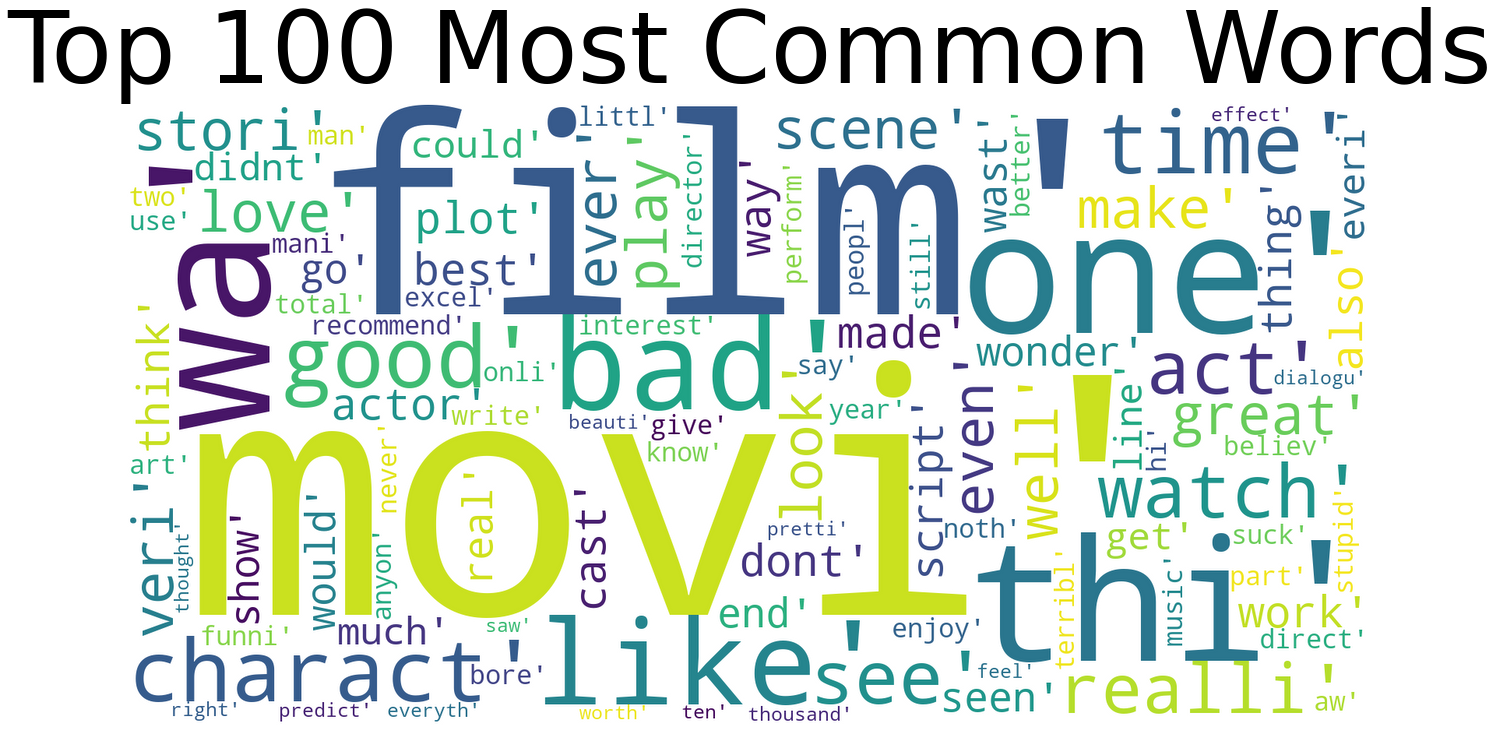

<Figure size 432x288 with 0 Axes>

In [41]:
mostcommon = FreqDist(my_words).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="lanczos")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

plt.savefig('top100.png')


In [42]:
top25w = pd.DataFrame(mostcommon)
top10w = top25w.iloc[:10]
top10w = top10w.rename({0:'Words', 1:'Occurencies'}, axis=1)
top10w

,Words,Occurencies
0,movi,207
1,film,184
2,one,91
3,thi,87
4,wa,67
5,bad,66
6,like,59
7,charact,58
8,good,56
9,time,49


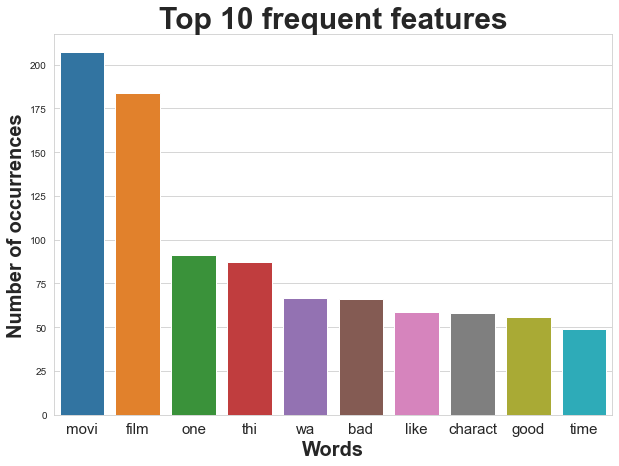

In [43]:
plt.figure(figsize=(10,7))
sns.set_style('whitegrid')

ax = sns.barplot(x='Words', y='Occurencies', data=top10w)

ax.set_xlabel('Words', size=20, fontweight='bold')
ax.set_ylabel('Number of occurrences', size=20, fontweight='bold')
ax.set_title("Top 10 frequent features", size=30, fontweight='bold')

plt.setp(ax.get_xticklabels(), rotation=0, size=15)

plt.savefig('top10.png')


### <font color=#225e71>Top 10 Most common words for Label 1
</font>

In [44]:
df_1 = df[(df['sentiment'] == 1)]
df_1.head(2)

,sentiment,sentence_clean,processed
4,1,"[best, scene, the, movi, when, gerardo, tri, f...",best scene the movi when gerardo tri find song...
7,1,"[saw, movi, today, thought, wa, good, effort, ...",saw movi today thought wa good effort good mes...


In [45]:
words = df_1['sentence_clean']
allwords = []

for w in words:
    allwords += w

In [46]:
my_words_1 = []
for i in allwords:
    if '' != i and "\t" not in i:
        my_words_1.append(i)


In [47]:
for w in stop_words:
    for i in my_words_1:
        if w == i:
            my_words_1.remove(w)


In [48]:
mostcommon_small1 = FreqDist(my_words_1).most_common(25)

top25w1 = pd.DataFrame(mostcommon_small1)
top10w1 = top25w1.iloc[:10]
top10w1 = top10w1.rename({0:'Words', 1:'Occurencies'}, axis=1)
top10w1

,Words,Occurencies
0,movi,101
1,film,98
2,one,41
3,good,35
4,like,34
5,thi,34
6,charact,33
7,wa,26
8,love,26
9,great,26


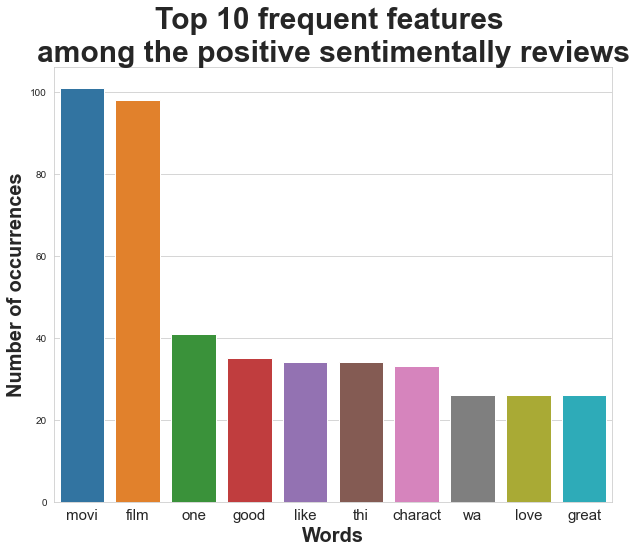

In [49]:
plt.figure(figsize=(10,8))
sns.set_style('whitegrid')

ax = sns.barplot(x='Words', y='Occurencies', data=top10w1)

ax.set_xlabel('Words', size=20, fontweight='bold')
ax.set_ylabel('Number of occurrences', size=20, fontweight='bold')
ax.set_title("Top 10 frequent features \namong the positive sentimentally reviews", size=30, fontweight='bold')

plt.setp(ax.get_xticklabels(), rotation=0, size=15)

plt.savefig('top10lab1.png')


### <font color=#225e71>Top 10 Most common words for Label 0
</font>

In [50]:
df_0 = df[(df['sentiment'] == 0)]
df_0.head(2)

,sentiment,sentence_clean,processed
0,0,"[veri, veri, slowmov, aimless, movi, a, distre...",veri veri slowmov aimless movi a distress drif...
1,0,"[sure, wa, lost, , flat, charact, the, audienc...",sure wa lost flat charact the audienc nearli ...


In [51]:
words = df_0['sentence_clean']
allwords = []

for w in words:
    allwords += w

In [52]:
my_words_0 = []
for i in allwords:
    if '' != i and "\t" not in i:
        my_words_0.append(i)


In [53]:
for w in stop_words:
    for i in my_words_0:
        if w == i:
            my_words_0.remove(w)


In [54]:
mostcommon_small0 = FreqDist(my_words_0).most_common(25)

top25w0 = pd.DataFrame(mostcommon_small0)
top10w0 = top25w0.iloc[:10]
top10w0 = top10w0.rename({0:'Words', 1:'Occurencies'}, axis=1)
top10w0

,Words,Occurencies
0,movi,106
1,film,86
2,bad,59
3,thi,53
4,one,50
5,wa,41
6,even,31
7,time,29
8,watch,26
9,charact,25


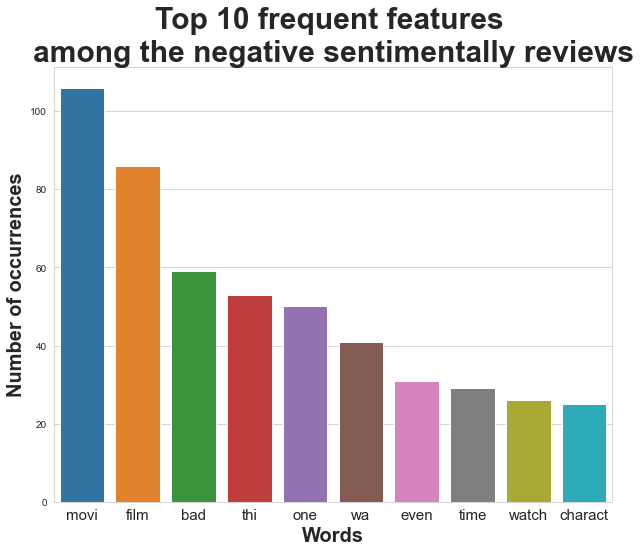

In [55]:
plt.figure(figsize=(10,8))
sns.set_style('whitegrid')

ax = sns.barplot(x='Words', y='Occurencies', data=top10w0)

ax.set_xlabel('Words', size=20, fontweight='bold')
ax.set_ylabel('Number of occurrences', size=20, fontweight='bold')
ax.set_title("Top 10 frequent features \namong the negative sentimentally reviews", size=30, fontweight='bold')

plt.setp(ax.get_xticklabels(), rotation=0, size=15)

plt.savefig('top10lab0.png')


# <font color=#225e71>Clustering</font>

In [56]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import adjusted_rand_score

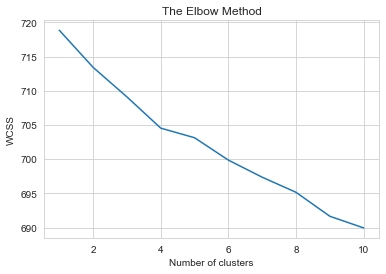

In [57]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10)
    kmeans.fit(X_tfidf)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.png')
plt.show()

In [58]:
def clustering_kmeans(clusters, max_iter, n_init):
    
    model = KMeans(n_clusters=clusters, init='k-means++', max_iter=max_iter, n_init=n_init)
    model.fit(X_tfidf)
    
    cluster_centers = model.cluster_centers_
    identified_clusters = model.fit_predict(X_tfidf)
    
    data_with_clusters = imdb.copy()
    data_with_clusters['Cluster'] = identified_clusters
    
    return data_with_clusters
    

In [59]:
def words_occurencies_by_cluster(dataset, Title, pictName, figSize):
    cluster_count = len(dataset['Cluster'].unique())
    mydflist = []
    regd = []
    for cluster in range(0, cluster_count):
        datasetX = dataset[(dataset['Cluster'] == cluster)]
        
        words_of_dataset = datasetX[["sentence_clean", 'Cluster']]
        allwords = []
        
        for w in words_of_dataset['sentence_clean']:
            allwords+=w
        
        my_words = []
        for i in allwords:
            if '' != i and "\t" not in i:
                my_words.append(i)
                
        for w in stop_words:
            for i in my_words:
                if w == i:
                    my_words.remove(w)
        
        mostcommon_small = FreqDist(my_words).most_common(10)
        top10d = pd.DataFrame(mostcommon_small)
        top10d = top10d.rename({0:'Words', 1:'Occurrences'}, axis=1)
        top10d.insert(column='Cluster', loc=top10d.shape[-1], value=cluster)
        mydflist.append(top10d)
        regd.append('Cluster '+ str(cluster))
    
    
    top10_of_clusters = mydflist[0]
    for i in range(1, len(mydflist)):
        top10_of_clusters = pd.concat([top10_of_clusters, mydflist[i]])
        
    plt.figure(figsize=figSize)
    sns.set_style('whitegrid')

    ax = sns.barplot(x='Words', y='Occurrences', data=top10_of_clusters, hue='Cluster')

    ax.set_xlabel('Words', size=20, fontweight='bold')
    ax.set_ylabel('Number of occurrences', size=20, fontweight='bold')
    
    leg = plt.legend(fontsize='x-large', loc=1)
    
    i=0
    for reg in regd:
        leg.get_texts()[i].set_text(reg)
        i+=1

#     fig.tight_layout()
#     sns.despine()

    
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right', size=15)
    
    ax.set_title(Title, size=30, fontweight='bold')
    pictName = pictName + '.png'
    plt.savefig(pictName)


# <font color=#225e71>2 Clusters</font> 

In [60]:
two_cl = clustering_kmeans(2, 200, 10)
two_cl

,sentence,sentiment,sentence_clean,Cluster
0,"A very, very, very slow-moving, aimless movie ...",0,"[veri, veri, slowmov, aimless, movi, a, distre...",0
1,Not sure who was more lost - the flat characte...,0,"[sure, wa, lost, , flat, charact, the, audienc...",1
2,Attempting artiness with black & white and cle...,0,"[attempt, arti, black, , white, clever, camera...",0
3,Very little music or anything to speak of.,0,"[littl, music, anyth, speak, , ]",1
4,The best scene in the movie was when Gerardo i...,1,"[best, scene, the, movi, when, gerardo, tri, f...",0
...,...,...,...,...
743,I just got bored watching Jessice Lange take h...,0,"[just, got, bore, watch, jessic, lang, take, c...",1
744,"Unfortunately, any virtue in this film's produ...",0,"[unfortun, virtu, thi, film, product, work, lo...",1
745,"In a word, it is embarrassing.",0,"[a, word, is, embarrass, , ]",1
746,Exceptionally bad!,0,"[except, bad, , ]",1


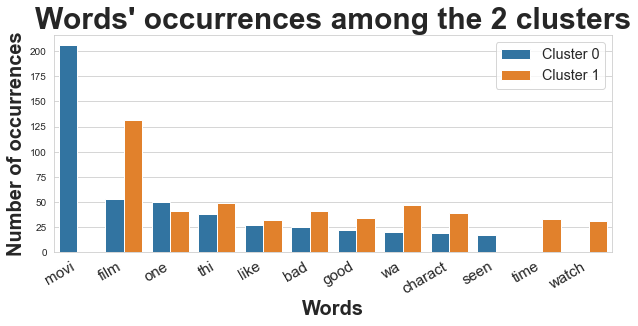

In [61]:
words_occurencies_by_cluster(two_cl, "Words' occurrences among the 2 clusters", '2cluster_occurrences', (10,4))

# <font color=#225e71>3 Clusters</font> 

In [62]:
three_cl = clustering_kmeans(3, 300, 10)
three_cl

,sentence,sentiment,sentence_clean,Cluster
0,"A very, very, very slow-moving, aimless movie ...",0,"[veri, veri, slowmov, aimless, movi, a, distre...",0
1,Not sure who was more lost - the flat characte...,0,"[sure, wa, lost, , flat, charact, the, audienc...",1
2,Attempting artiness with black & white and cle...,0,"[attempt, arti, black, , white, clever, camera...",1
3,Very little music or anything to speak of.,0,"[littl, music, anyth, speak, , ]",0
4,The best scene in the movie was when Gerardo i...,1,"[best, scene, the, movi, when, gerardo, tri, f...",1
...,...,...,...,...
743,I just got bored watching Jessice Lange take h...,0,"[just, got, bore, watch, jessic, lang, take, c...",0
744,"Unfortunately, any virtue in this film's produ...",0,"[unfortun, virtu, thi, film, product, work, lo...",2
745,"In a word, it is embarrassing.",0,"[a, word, is, embarrass, , ]",0
746,Exceptionally bad!,0,"[except, bad, , ]",0


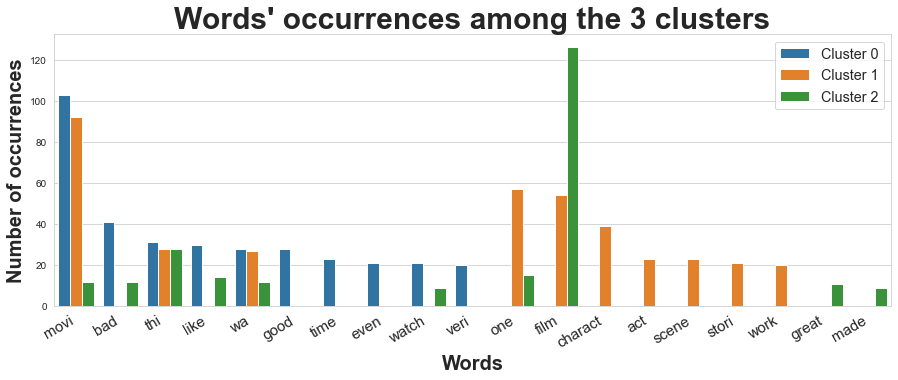

In [63]:
words_occurencies_by_cluster(three_cl, "Words' occurrences among the 3 clusters", '3cluster_occurrences', (15,5))

# <font color=#225e71>5 Clusters</font> 

In [64]:
five_cl = clustering_kmeans(5, 400, 10)
five_cl

,sentence,sentiment,sentence_clean,Cluster
0,"A very, very, very slow-moving, aimless movie ...",0,"[veri, veri, slowmov, aimless, movi, a, distre...",1
1,Not sure who was more lost - the flat characte...,0,"[sure, wa, lost, , flat, charact, the, audienc...",0
2,Attempting artiness with black & white and cle...,0,"[attempt, arti, black, , white, clever, camera...",2
3,Very little music or anything to speak of.,0,"[littl, music, anyth, speak, , ]",4
4,The best scene in the movie was when Gerardo i...,1,"[best, scene, the, movi, when, gerardo, tri, f...",2
...,...,...,...,...
743,I just got bored watching Jessice Lange take h...,0,"[just, got, bore, watch, jessic, lang, take, c...",4
744,"Unfortunately, any virtue in this film's produ...",0,"[unfortun, virtu, thi, film, product, work, lo...",1
745,"In a word, it is embarrassing.",0,"[a, word, is, embarrass, , ]",3
746,Exceptionally bad!,0,"[except, bad, , ]",4


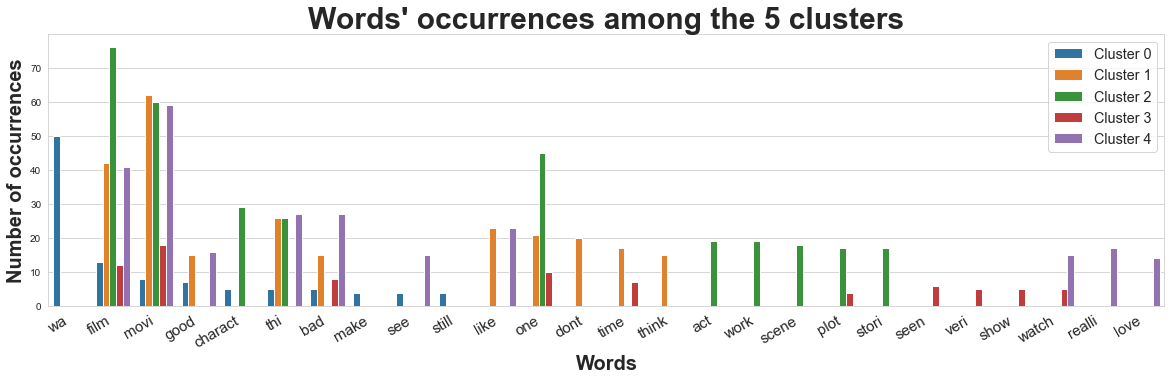

In [65]:
words_occurencies_by_cluster(five_cl, "Words' occurrences among the 5 clusters", '5cluster_occurrences', (20,5))

# <font color=#225e71>6 Clusters</font> 

In [66]:
six_cl = clustering_kmeans(6, 400, 10)
six_cl

,sentence,sentiment,sentence_clean,Cluster
0,"A very, very, very slow-moving, aimless movie ...",0,"[veri, veri, slowmov, aimless, movi, a, distre...",4
1,Not sure who was more lost - the flat characte...,0,"[sure, wa, lost, , flat, charact, the, audienc...",1
2,Attempting artiness with black & white and cle...,0,"[attempt, arti, black, , white, clever, camera...",2
3,Very little music or anything to speak of.,0,"[littl, music, anyth, speak, , ]",2
4,The best scene in the movie was when Gerardo i...,1,"[best, scene, the, movi, when, gerardo, tri, f...",5
...,...,...,...,...
743,I just got bored watching Jessice Lange take h...,0,"[just, got, bore, watch, jessic, lang, take, c...",1
744,"Unfortunately, any virtue in this film's produ...",0,"[unfortun, virtu, thi, film, product, work, lo...",0
745,"In a word, it is embarrassing.",0,"[a, word, is, embarrass, , ]",3
746,Exceptionally bad!,0,"[except, bad, , ]",3


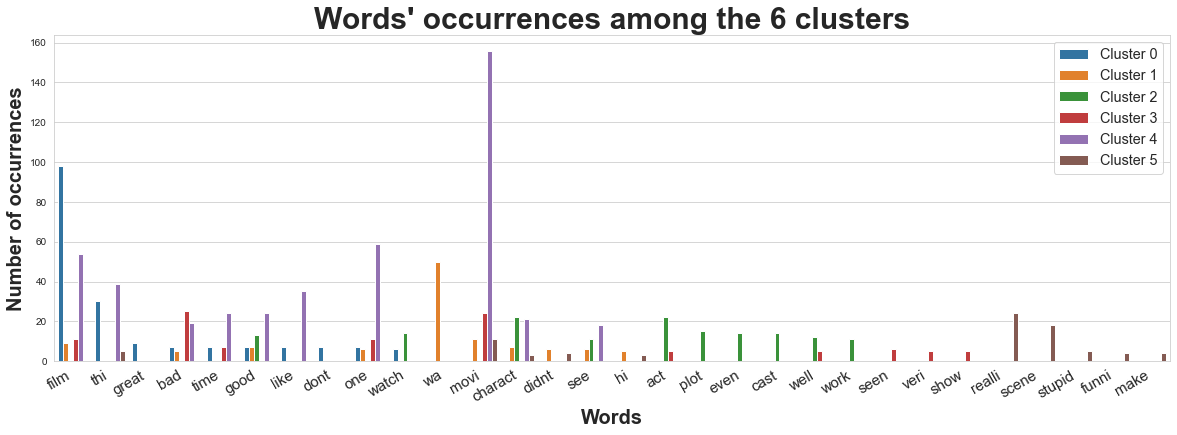

In [67]:
words_occurencies_by_cluster(six_cl, "Words' occurrences among the 6 clusters", '6cluster_occurrences', (20,6))

# <font color=#225e71>7 Clusters</font> 

In [68]:
sev_cl = clustering_kmeans(7, 400, 10)
sev_cl

,sentence,sentiment,sentence_clean,Cluster
0,"A very, very, very slow-moving, aimless movie ...",0,"[veri, veri, slowmov, aimless, movi, a, distre...",3
1,Not sure who was more lost - the flat characte...,0,"[sure, wa, lost, , flat, charact, the, audienc...",5
2,Attempting artiness with black & white and cle...,0,"[attempt, arti, black, , white, clever, camera...",1
3,Very little music or anything to speak of.,0,"[littl, music, anyth, speak, , ]",4
4,The best scene in the movie was when Gerardo i...,1,"[best, scene, the, movi, when, gerardo, tri, f...",2
...,...,...,...,...
743,I just got bored watching Jessice Lange take h...,0,"[just, got, bore, watch, jessic, lang, take, c...",4
744,"Unfortunately, any virtue in this film's produ...",0,"[unfortun, virtu, thi, film, product, work, lo...",6
745,"In a word, it is embarrassing.",0,"[a, word, is, embarrass, , ]",4
746,Exceptionally bad!,0,"[except, bad, , ]",5


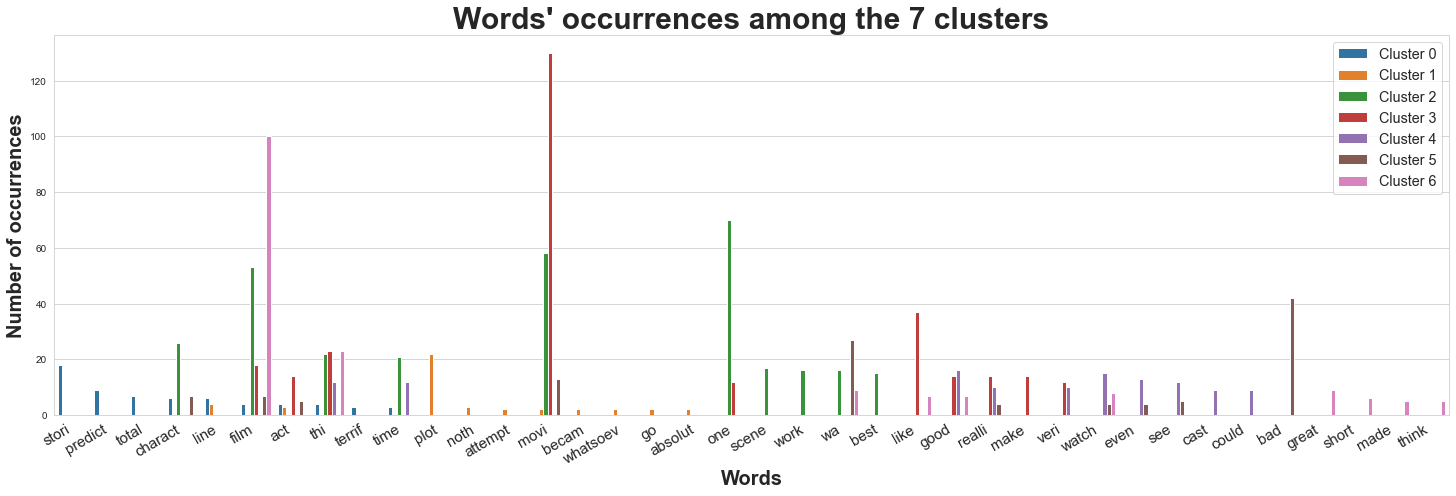

In [69]:
words_occurencies_by_cluster(sev_cl, "Words' occurrences among the 7 clusters", '7cluster_occurrences', (25,7))

# <font color=#225e71>8 Clusters</font> 

In [70]:
eight_cl = clustering_kmeans(8, 400, 10)
eight_cl

,sentence,sentiment,sentence_clean,Cluster
0,"A very, very, very slow-moving, aimless movie ...",0,"[veri, veri, slowmov, aimless, movi, a, distre...",6
1,Not sure who was more lost - the flat characte...,0,"[sure, wa, lost, , flat, charact, the, audienc...",5
2,Attempting artiness with black & white and cle...,0,"[attempt, arti, black, , white, clever, camera...",2
3,Very little music or anything to speak of.,0,"[littl, music, anyth, speak, , ]",2
4,The best scene in the movie was when Gerardo i...,1,"[best, scene, the, movi, when, gerardo, tri, f...",6
...,...,...,...,...
743,I just got bored watching Jessice Lange take h...,0,"[just, got, bore, watch, jessic, lang, take, c...",4
744,"Unfortunately, any virtue in this film's produ...",0,"[unfortun, virtu, thi, film, product, work, lo...",5
745,"In a word, it is embarrassing.",0,"[a, word, is, embarrass, , ]",2
746,Exceptionally bad!,0,"[except, bad, , ]",3


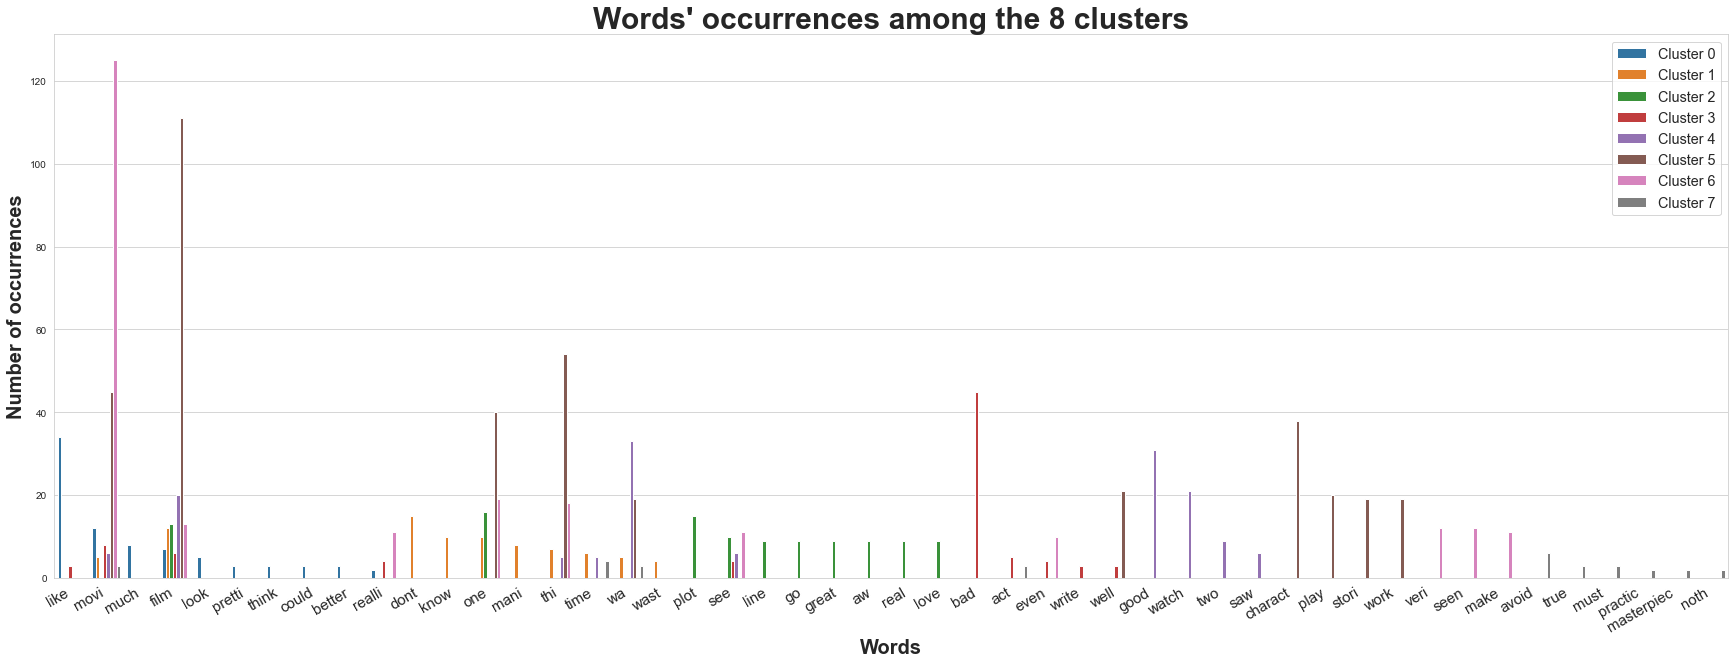

In [71]:
words_occurencies_by_cluster(eight_cl, "Words' occurrences among the 8 clusters", '8cluster_occurrences', (30,10))

# <font color=#225e71>9 Clusters</font> 

In [72]:
nine_cl = clustering_kmeans(9, 400, 10)
nine_cl

,sentence,sentiment,sentence_clean,Cluster
0,"A very, very, very slow-moving, aimless movie ...",0,"[veri, veri, slowmov, aimless, movi, a, distre...",7
1,Not sure who was more lost - the flat characte...,0,"[sure, wa, lost, , flat, charact, the, audienc...",5
2,Attempting artiness with black & white and cle...,0,"[attempt, arti, black, , white, clever, camera...",5
3,Very little music or anything to speak of.,0,"[littl, music, anyth, speak, , ]",4
4,The best scene in the movie was when Gerardo i...,1,"[best, scene, the, movi, when, gerardo, tri, f...",2
...,...,...,...,...
743,I just got bored watching Jessice Lange take h...,0,"[just, got, bore, watch, jessic, lang, take, c...",4
744,"Unfortunately, any virtue in this film's produ...",0,"[unfortun, virtu, thi, film, product, work, lo...",3
745,"In a word, it is embarrassing.",0,"[a, word, is, embarrass, , ]",3
746,Exceptionally bad!,0,"[except, bad, , ]",6


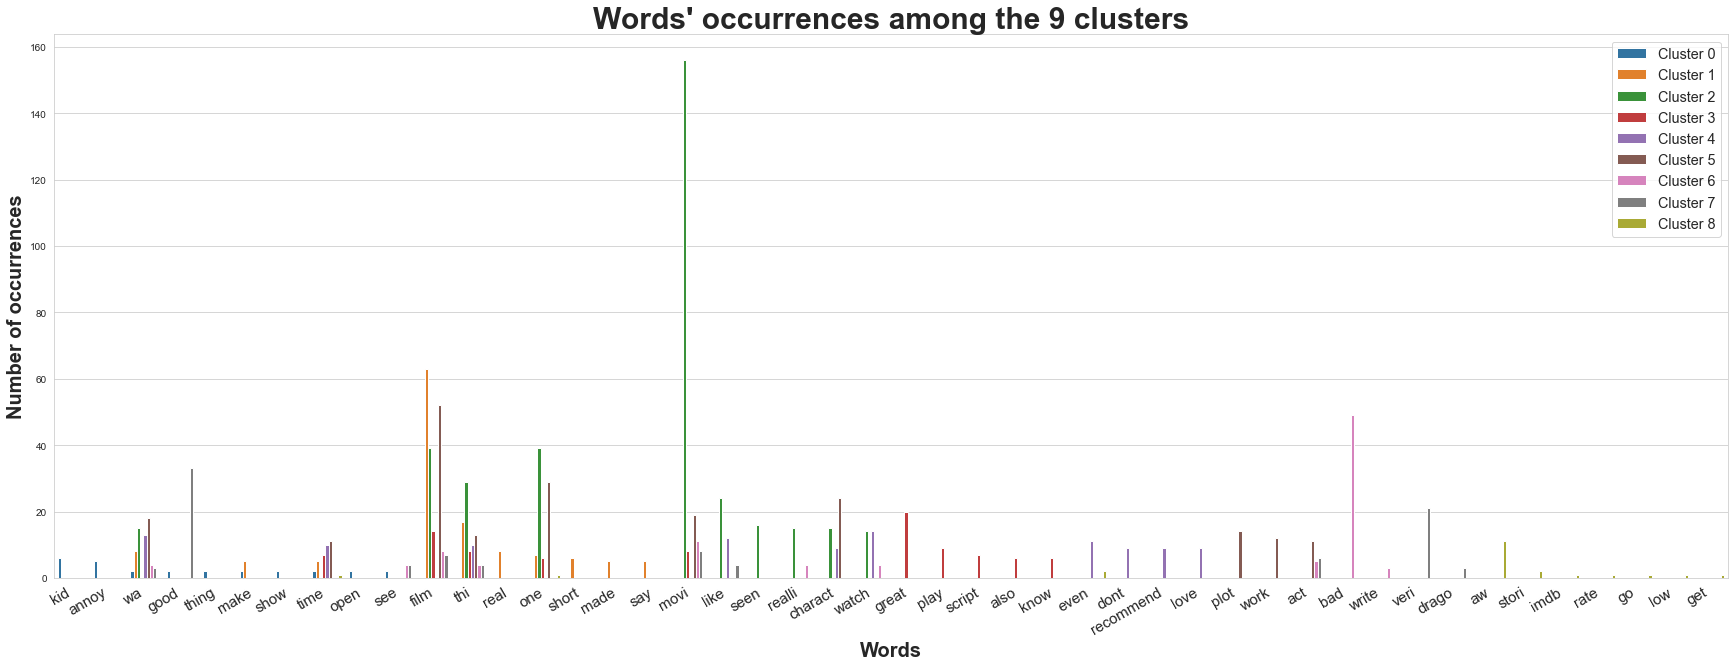

In [73]:
words_occurencies_by_cluster(nine_cl, "Words' occurrences among the 9 clusters", '9cluster_occurrences', (30,10))

# <font color=#225e71>Classification</font> 


### <font color=#225e71>Random Forest</font> 


In [74]:
X_features = pd.DataFrame(sentences_tfidf.toarray())

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_features, imdb['sentiment'], test_size=0.2)

In [76]:
rf = RandomForestClassifier(max_depth=10)
rf_model = rf.fit(X_train, y_train)

In [77]:
y_pred = rf_model.predict(X_test)

In [78]:
precision = precision_score(y_test, y_pred, pos_label=0)
recall = recall_score(y_test, y_pred, pos_label=0)
print('Precision for 0 label: {} \nRecall for 0 label: {}'.format(round(precision, 3), round(recall, 3)))

Precision for 0 label: 0.736 
Recall for 0 label: 0.542


In [79]:
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
print('Precision for 1 label: {} \nRecall for 1 label: {}'.format(round(precision, 3), round(recall, 3)))

Precision for 1 label: 0.66 
Recall for 1 label: 0.821


In [80]:
print('Confusion matrix:\n {}'.format(confusion_matrix(y_test, y_pred)))
print('\n')
print('Classification report:\n {}'.format(classification_report(y_test, y_pred)))
print('\n')
print('Model\'s accuracy:\n {}'.format(round(accuracy_score(y_test, y_pred),2)))

Confusion matrix:
 [[39 33]
 [14 64]]


Classification report:
               precision    recall  f1-score   support

           0       0.74      0.54      0.62        72
           1       0.66      0.82      0.73        78

    accuracy                           0.69       150
   macro avg       0.70      0.68      0.68       150
weighted avg       0.70      0.69      0.68       150



Model's accuracy:
 0.69


### <font color=#225e71>Decision Trees</font> 


In [81]:
clf = tree.DecisionTreeClassifier(max_leaf_nodes=100, min_samples_leaf=30, max_depth=10)
clf.fit(X_train,y_train)

predict3 = clf.predict(X_train, check_input=True)


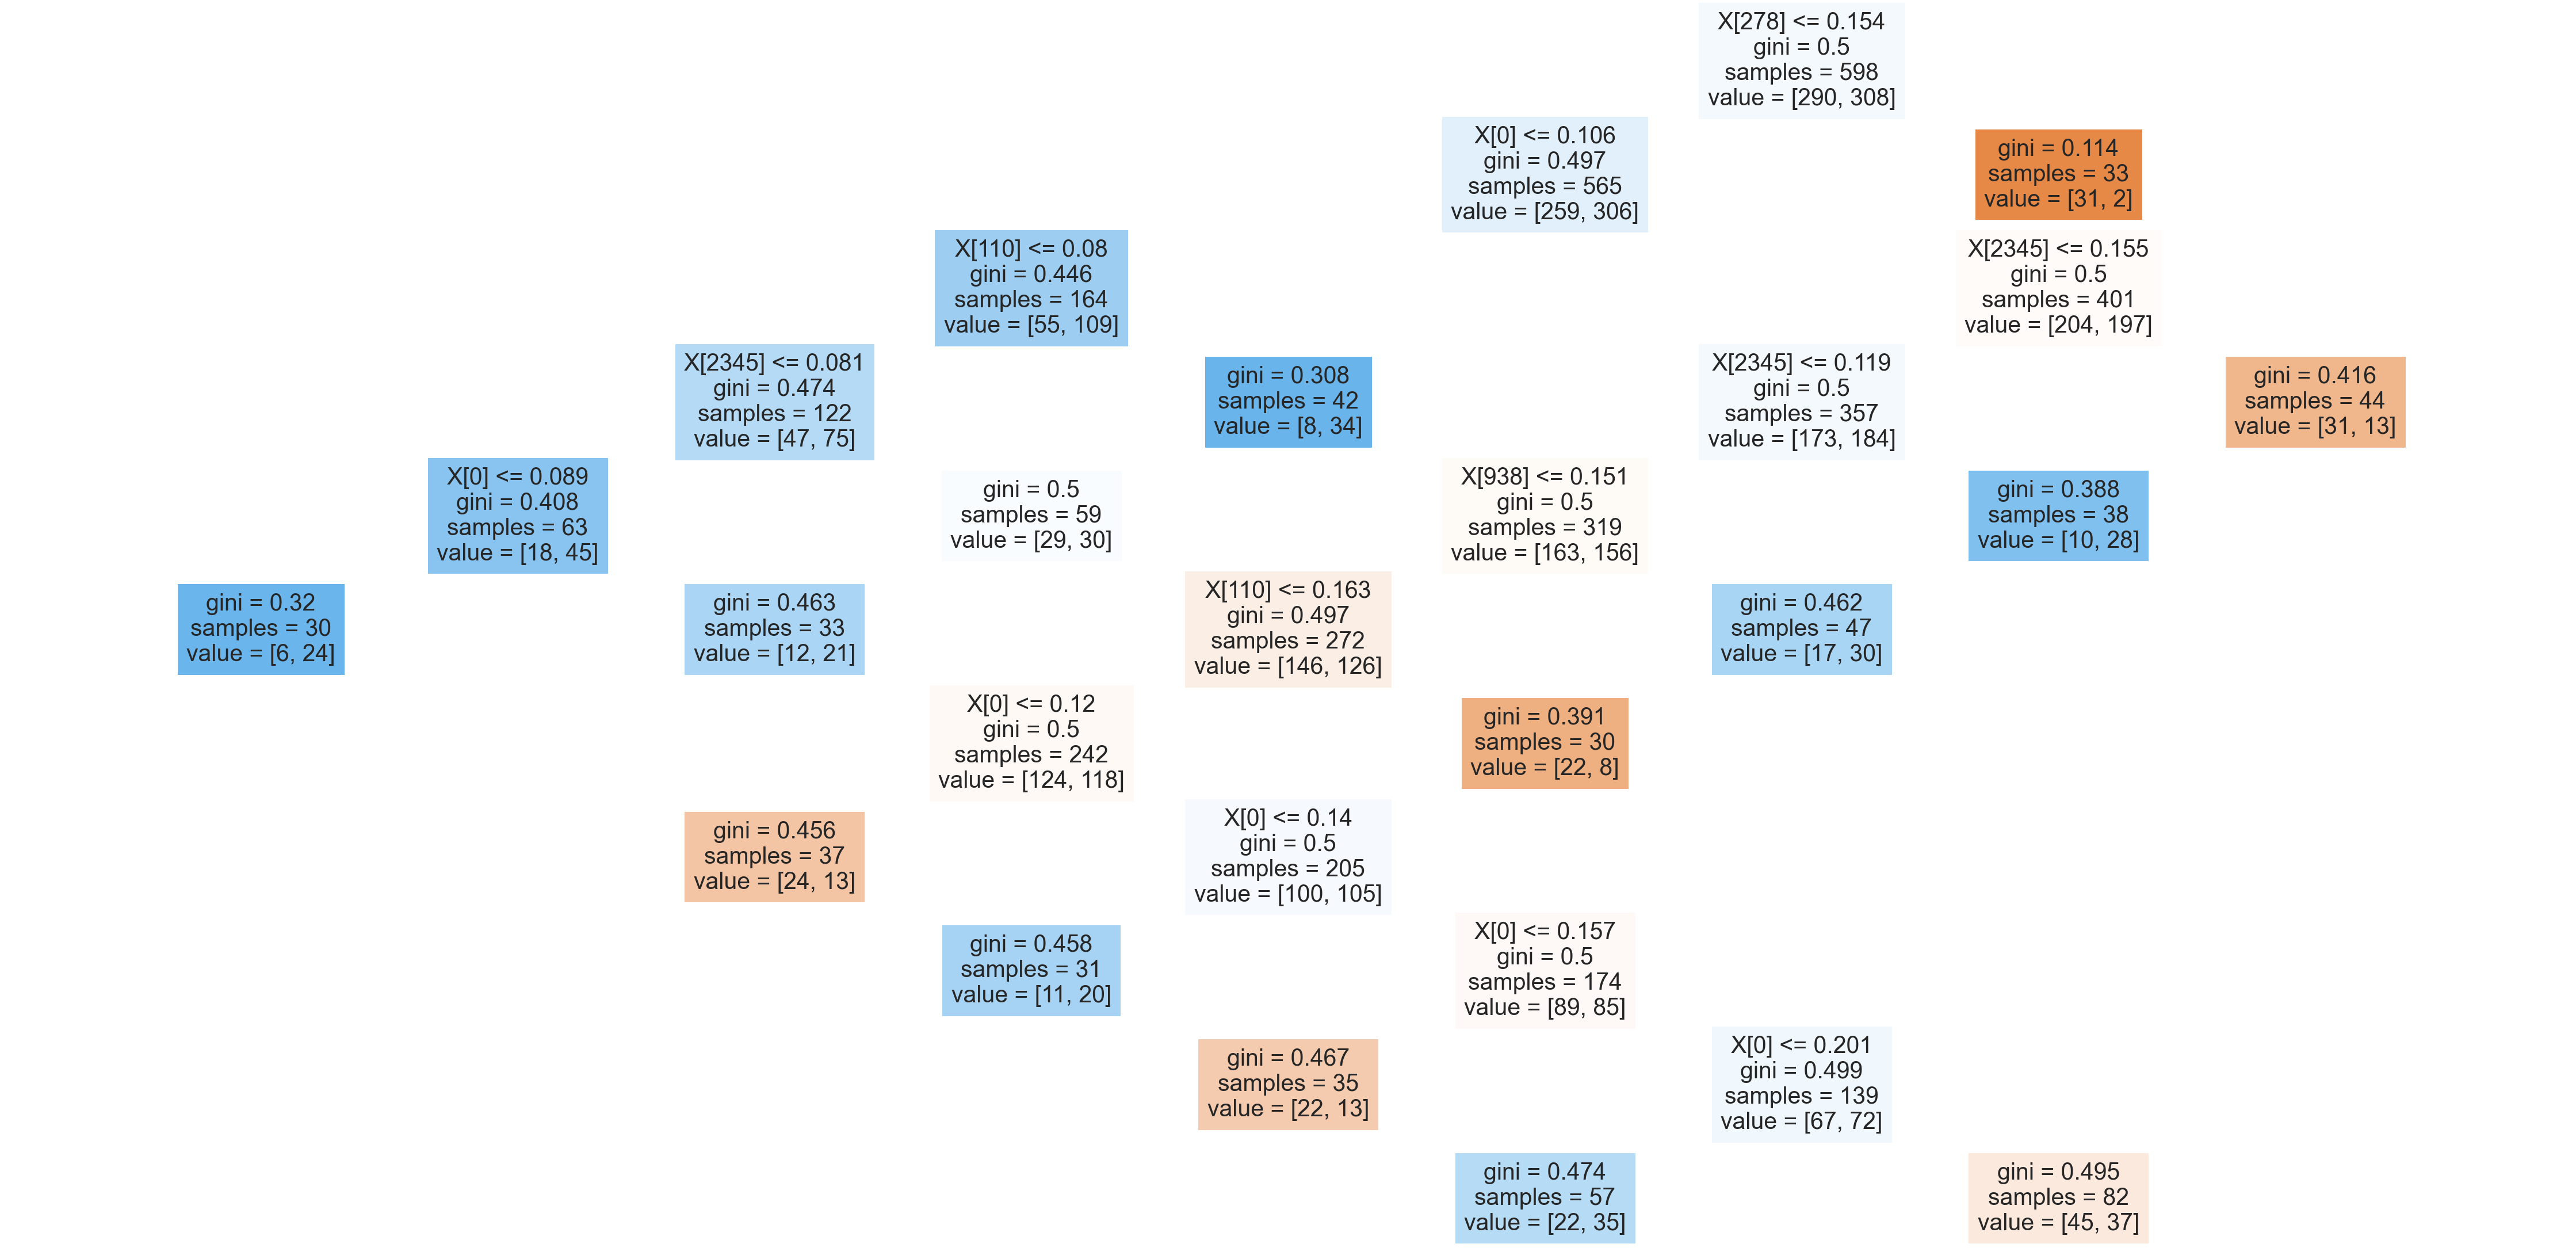

In [82]:
fig = plt.figure(figsize=(80,40))
_ = tree.plot_tree(clf,
                   filled=True)

In [83]:
predictions = clf.predict(X_test)

In [84]:
print('Confusion matrix:\n {}'.format(confusion_matrix(y_test, predictions)))
print('\n')
print('Classification report:\n {}'.format(classification_report(y_test, predictions)))
print('\n')
print('Model\'s accuracy:\n {}'.format(round(accuracy_score(y_test, predictions),2)))

Confusion matrix:
 [[34 38]
 [28 50]]


Classification report:
               precision    recall  f1-score   support

           0       0.55      0.47      0.51        72
           1       0.57      0.64      0.60        78

    accuracy                           0.56       150
   macro avg       0.56      0.56      0.55       150
weighted avg       0.56      0.56      0.56       150



Model's accuracy:
 0.56


### <font color=#225e71>Support Vector Machine</font> 


In [85]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [86]:
param_grid = {'C': [0.1, 1],
              'gamma': [1, 0.1]}

In [87]:
grid = GridSearchCV(SVC(), param_grid, verbose=3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... C=0.1, gamma=1, score=0.517, total=   1.4s
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, score=0.517, total=   1.2s
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, score=0.517, total=   1.3s
[CV] C=0.1, gamma=1 ..................................................
[CV] ...................... C=0.1, gamma=1, score=0.513, total=   1.1s
[CV] C=0.1, gamma=1 ..................................................
[CV] ...................... C=0.1, gamma=1, score=0.513, total=   1.2s
[CV] C=0.1, gamma=0.1 ................................................
[CV] .................... C=0.1, gamma=0.1, score=0.517, total=   1.1s
[CV] C=0.1, gamma=0.1 ................................................
[CV] .................... C=0.1, gamma=0.1, score=0.517, total=   1.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] .................... C=0.1, gamma=0.1, score=0.517, total=   1.2s
[CV] C=0.1, gamma=0.1 ................................................
[CV] .................... C=0.1, gamma=0.1, score=0.513, total=   1.1s
[CV] C=0.1, gamma=0.1 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   21.7s finished


GridSearchCV(estimator=SVC(), param_grid={'C': [0.1, 1], 'gamma': [1, 0.1]},
             verbose=3)

In [88]:
grid.best_params_

{'C': 1, 'gamma': 1}

In [89]:
grid.best_estimator_

SVC(C=1, gamma=1)

In [90]:
grid_predictions = grid.predict(X_test)
grid_predictions

array([0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1], dtype=int64)

In [91]:
my_model = SVC(kernel='linear', C=1.0, gamma=1)
my_model = my_model.fit(X_train, y_train )

In [92]:
my_model

SVC(gamma=1, kernel='linear')

In [93]:
support_vector_indices = my_model.support_
print(support_vector_indices)

[  1   4   5   6   8  10  12  13  15  16  20  27  36  37  44  45  48  50
  52  54  55  56  64  65  66  72  74  75  76  79  84  86  88  91  92  93
  94  97  98 100 102 103 108 112 115 116 120 121 125 126 128 131 132 134
 135 137 138 139 140 141 142 143 146 147 148 150 153 156 157 158 159 161
 163 164 165 167 170 171 175 177 179 180 182 183 184 188 192 193 197 198
 199 204 209 210 211 212 213 215 217 218 225 227 230 234 235 236 240 242
 244 245 246 247 248 249 250 251 252 253 256 257 258 260 264 266 267 268
 270 272 274 275 276 281 286 290 292 294 295 296 297 298 299 306 307 311
 312 313 317 322 325 328 330 331 335 336 337 339 343 346 348 349 350 353
 354 355 359 360 361 362 368 370 371 372 377 380 383 384 389 395 397 401
 402 403 404 406 410 420 422 423 434 435 436 438 439 440 443 444 445 449
 450 453 454 459 460 461 463 464 466 468 470 471 472 474 476 480 481 483
 487 498 501 502 505 506 511 514 516 519 521 522 525 526 528 531 532 534
 539 541 544 546 548 550 553 559 560 561 562 564 56

In [94]:
# Get number of support vectors per class
support_vectors_per_class = my_model.n_support_
print(support_vectors_per_class)

[257 278]


In [95]:
predictions = my_model.predict(X_test)

In [96]:
predictions

array([0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1], dtype=int64)

In [97]:
print('Confusion matrix:\n {}'.format(confusion_matrix(y_test, predictions)))
print('\n')
print('Classification report:\n {}'.format(classification_report(y_test, predictions)))
print('\n')
print('Model\'s accuracy:\n {}'.format(round(accuracy_score(y_test, predictions),2)))

Confusion matrix:
 [[49 23]
 [13 65]]


Classification report:
               precision    recall  f1-score   support

           0       0.79      0.68      0.73        72
           1       0.74      0.83      0.78        78

    accuracy                           0.76       150
   macro avg       0.76      0.76      0.76       150
weighted avg       0.76      0.76      0.76       150



Model's accuracy:
 0.76


### <font color=#225e71>Naive Bayes</font> 


In [98]:
nb_model = MultinomialNB()
nb_model = nb_model.fit(X_train, y_train)

In [99]:
nb_preds = nb_model.predict(X_test)
nb_preds

array([0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0], dtype=int64)

In [100]:
print('Confusion matrix:\n {}'.format(confusion_matrix(y_test, nb_preds)))
print('\n')
print('Classification report:\n {}'.format(classification_report(y_test, nb_preds)))
print('\n')
print('Model\'s accuracy:\n {}'.format(round(accuracy_score(y_test, nb_preds),2)))

Confusion matrix:
 [[51 21]
 [16 62]]


Classification report:
               precision    recall  f1-score   support

           0       0.76      0.71      0.73        72
           1       0.75      0.79      0.77        78

    accuracy                           0.75       150
   macro avg       0.75      0.75      0.75       150
weighted avg       0.75      0.75      0.75       150



Model's accuracy:
 0.75


NameError: name 'T' is not defined